In [2]:
import boto3
from dotenv import dotenv_values
import pandas as pd
import re
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

config = dotenv_values(".env")
aws_access_key = config["AWS_ACCESS_KEY"]
aws_secret_access_key = config["AWS_SECRET_ACCESS_KEY"]

In [3]:

session = boto3.Session(aws_access_key_id=aws_access_key, aws_secret_access_key=aws_secret_access_key)

In [4]:
def read_latest_csv(bucket_name, session = session):
    
    s3 = session.resource('s3')
    bucket = s3.Bucket(bucket_name)

    # Get the list of objects in the bucket and sort them by date in descending order
    files = sorted(bucket.objects.all(),
                   key=lambda obj: obj.last_modified, reverse=True)

    # Find the first file with a valid date format in the name
    for file in files:
        file_name = file.key
        try:
            date_str = file_name.split('_')[1].split(
                '.')[0]  # Extract date from file name
            # Add more checks here if required to ensure the date format is valid
            obj = s3.Object(bucket_name, file_name)
            df = pd.read_csv(obj.get()['Body'])
            return df
        except IndexError:
            pass

    return None  # No valid files found


In [5]:
bucket_name = 'rafpang-airflow-youtube-bucket'
fcc_df = read_latest_csv(bucket_name)
fcc_df.head()


,Unnamed: 0,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,durationSecs
0,0,MIL2BK02X8A,freeCodeCamp.org,Pointers in C for Absolute Beginners – Full Co...,Finally understand pointers in C in this cours...,NaN,2023-06-15 23:06:14,21173,1275.0,NaN,52,PT2H4M29S,hd,False,0 days 02:04:29
1,1,ZTPcRWK0ytE,freeCodeCamp.org,Microsoft Power Platform Fundamentals (PL-900)...,Prepare for the Microsoft Power Platform Funda...,NaN,2023-06-13 21:23:05,18451,670.0,NaN,32,PT3H26M,hd,False,0 days 03:26:00
2,2,BpPEoZW5IiY,freeCodeCamp.org,Learn Rust Programming - Complete Course 🦀,In this comprehensive Rust course for beginner...,NaN,2023-06-08 20:43:32,78959,3495.0,NaN,191,PT13H59M10S,hd,False,0 days 13:59:10
3,3,IA3WxTTPXqQ,freeCodeCamp.org,Deep Learning for Computer Vision with Python ...,Learn the basics of computer vision with deep ...,NaN,2023-06-06 22:04:19,154378,6339.0,NaN,239,P1DT13H16M41S,hd,True,1 days 13:16:41
4,4,_IgbB24scLI,freeCodeCamp.org,Neo4j Course for Beginners,Learn how to use Neo4j with Java Spring Boot a...,NaN,2023-06-01 22:42:30,34773,960.0,NaN,46,PT5H24M59S,hd,True,0 days 05:24:59


### What is the most viewed Javascript framework tutorial?
React, Angular, Vue, or Svelte?

In [6]:
# Define the JavaScript frameworks you want to extract and their respective colors
framework_colors = {'React': 'rgb(0, 157, 255)', 'Vue': 'rgb(0, 204, 102)',
                    'Angular': 'rgb(255, 77, 77)', 'Svelte': 'rgb(255, 153, 51)'}

# Create a new column for the extracted JavaScript framework
fcc_df['javascript_framework'] = fcc_df['title'].str.extract(
    f"({'|'.join(framework_colors.keys())})", flags=re.IGNORECASE)

# Group the dataframe by the JavaScript framework column and calculate the sum of view counts
framework_view_counts = fcc_df.groupby('javascript_framework')[
    'viewCount'].sum().reset_index()

# Sort the dataframe by view count in descending order
framework_view_counts = framework_view_counts.sort_values(
    'viewCount', ascending=False)

# Create a bar chart using Plotly with color coding
fig = px.bar(framework_view_counts, x='javascript_framework', y='viewCount', color='javascript_framework',
             labels={'javascript_framework': 'JavaScript Framework',
                     'viewCount': 'View Count'},
             color_discrete_map=framework_colors)

# Update layout properties
fig.update_layout(
    title={
        'text': '<b>View Count per JavaScript Framework</b>',
        'x': 0.5,
        'y': 0.95,
        'xanchor': 'center',
        'yanchor': 'top',
    },
    xaxis_tickangle=-45,
    font=dict(family='Arial, sans-serif'),
)

fig.show()

In [7]:
# Define the list of programming languages to search for
programming_languages = ['Python', 'JavaScript', 'Java', 'C\+\+', 'Ruby',]

# Create a new column for the extracted programming language
fcc_df['programming_language'] = fcc_df['title'].str.lower().str.extract(r'(' + '|'.join(map(str.lower, programming_languages)) + r')', flags=re.IGNORECASE)

# Group the dataframe by the programming language column and calculate the sum of viewCount
language_view_counts = fcc_df.groupby('programming_language')['viewCount'].sum().reset_index()

# Sort the dataframe by viewCount in descending order
language_view_counts = language_view_counts.sort_values('viewCount', ascending=False)

# Create a bar chart using Plotly
fig = px.bar(language_view_counts, x='programming_language', y='viewCount',
             labels={'programming_language': 'Programming Language', 'viewCount': 'View Count'},
             color='programming_language',
             color_discrete_sequence=px.colors.qualitative.Dark2)

# Update layout properties
fig.update_layout(
    title={
        'text': '<b>View Count per Programming Language</b>',
        'x': 0.5,
        'y': 0.95,
        'xanchor': 'center',
        'yanchor': 'top',
    },
    xaxis_tickangle=-45,
    font=dict(family='Arial, sans-serif'),
)

fig.show()

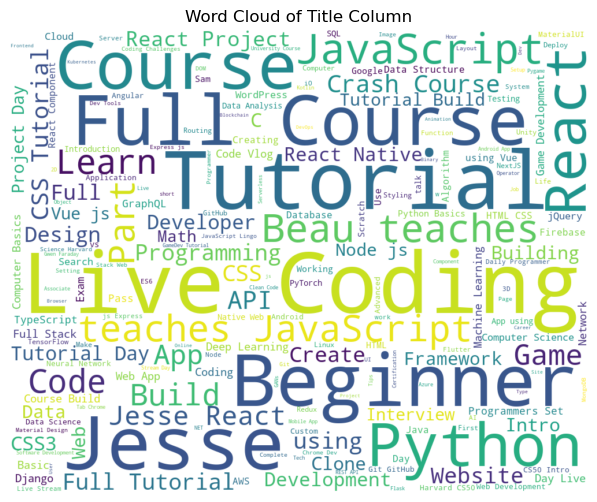

In [8]:
from wordcloud import WordCloud

# Concatenate all the titles into a single string
titles_combined = ' '.join(fcc_df['title'].astype(str))

# Create a WordCloud object
wordcloud = WordCloud(width=1000, height=800, background_color='white').generate(titles_combined)

# Plot the WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Title Column')
plt.show()

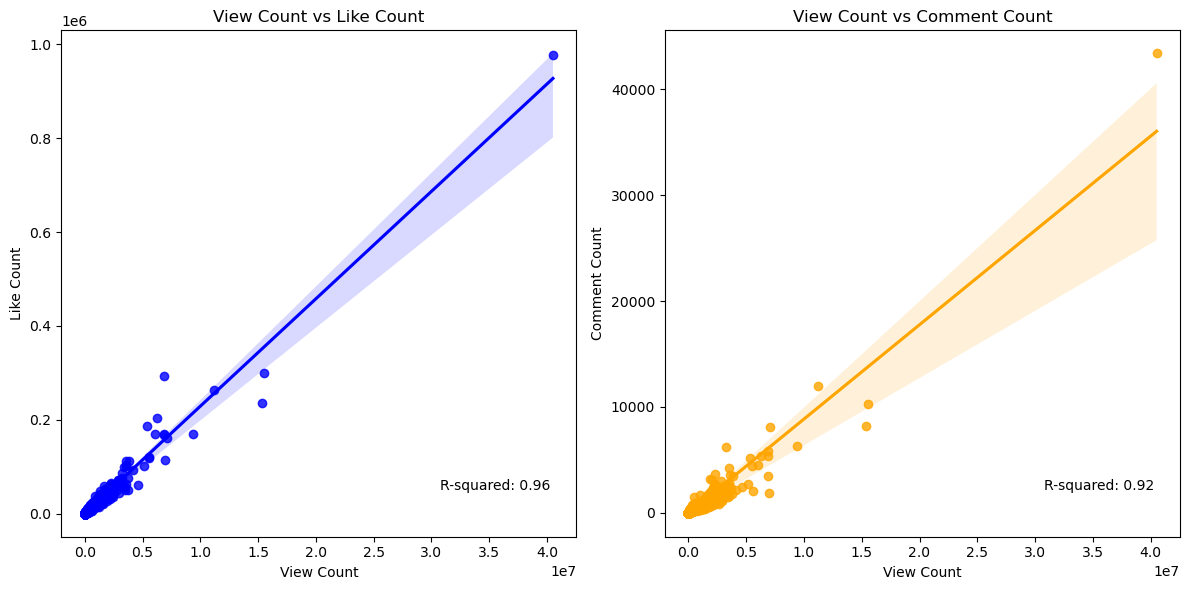

In [9]:

# Set the figure and axis objects
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot viewCount vs likeCount (blue plot)
sns.regplot(data=fcc_df, x='viewCount',
            y='likeCount', ax=axes[0], color='blue')
axes[0].set_title('View Count vs Like Count')
axes[0].set_xlabel('View Count')
axes[0].set_ylabel('Like Count')

# Calculate and display the R-squared value for viewCount vs likeCount
r_squared_like = fcc_df['viewCount'].corr(fcc_df['likeCount']) ** 2
axes[0].text(0.95, 0.1, f'R-squared: {r_squared_like:.2f}',
             ha='right', va='center', transform=axes[0].transAxes)

# Plot viewCount vs commentCount (orange plot)
sns.regplot(data=fcc_df, x='viewCount',
            y='commentCount', ax=axes[1], color='orange')
axes[1].set_title('View Count vs Comment Count')
axes[1].set_xlabel('View Count')
axes[1].set_ylabel('Comment Count')

# Calculate and display the R-squared value for viewCount vs commentCount
r_squared_comment = fcc_df['viewCount'].corr(fcc_df['commentCount']) ** 2
axes[1].text(0.95, 0.1, f'R-squared: {r_squared_comment:.2f}',
             ha='right', va='center', transform=axes[1].transAxes)

# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()


In [10]:
pattern = r'(\d+) days (\d+):(\d+):(\d+)'
fcc_df[['days', 'hours', 'minutes', 'seconds']] = fcc_df['durationSecs'].str.extract(pattern).astype(int)

# Calculate total hours
fcc_df['totalHours'] = fcc_df['days'] * 24 + fcc_df['hours'] + fcc_df['minutes'] / 60 + fcc_df['seconds'] / 3600

fcc_df.head()

,Unnamed: 0,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,...,definition,caption,durationSecs,javascript_framework,programming_language,days,hours,minutes,seconds,totalHours
0,0,MIL2BK02X8A,freeCodeCamp.org,Pointers in C for Absolute Beginners – Full Co...,Finally understand pointers in C in this cours...,NaN,2023-06-15 23:06:14,21173,1275.0,NaN,...,hd,False,0 days 02:04:29,NaN,NaN,0,2,4,29,2.074722
1,1,ZTPcRWK0ytE,freeCodeCamp.org,Microsoft Power Platform Fundamentals (PL-900)...,Prepare for the Microsoft Power Platform Funda...,NaN,2023-06-13 21:23:05,18451,670.0,NaN,...,hd,False,0 days 03:26:00,NaN,NaN,0,3,26,0,3.433333
2,2,BpPEoZW5IiY,freeCodeCamp.org,Learn Rust Programming - Complete Course 🦀,In this comprehensive Rust course for beginner...,NaN,2023-06-08 20:43:32,78959,3495.0,NaN,...,hd,False,0 days 13:59:10,NaN,NaN,0,13,59,10,13.986111
3,3,IA3WxTTPXqQ,freeCodeCamp.org,Deep Learning for Computer Vision with Python ...,Learn the basics of computer vision with deep ...,NaN,2023-06-06 22:04:19,154378,6339.0,NaN,...,hd,True,1 days 13:16:41,NaN,python,1,13,16,41,37.278056
4,4,_IgbB24scLI,freeCodeCamp.org,Neo4j Course for Beginners,Learn how to use Neo4j with Java Spring Boot a...,NaN,2023-06-01 22:42:30,34773,960.0,NaN,...,hd,True,0 days 05:24:59,NaN,NaN,0,5,24,59,5.416389


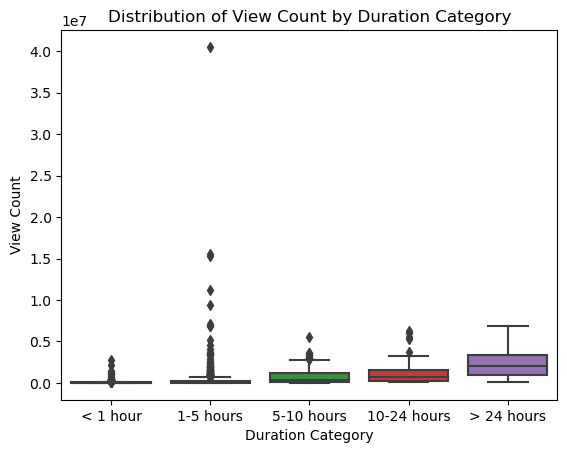

In [11]:
bin_edges = [0, 1, 5, 10, 24, fcc_df['totalHours'].max()]
bin_labels = ['< 1 hour', '1-5 hours', '5-10 hours', '10-24 hours', '> 24 hours']

# Partition the totalHours column into categories
fcc_df['category'] = pd.cut(fcc_df['totalHours'], bins=bin_edges, labels=bin_labels)

# Create the box plot
sns.boxplot(x='category', y='viewCount', data=fcc_df)

# Set labels and title
plt.xlabel('Duration Category')
plt.ylabel('View Count')
plt.title('Distribution of View Count by Duration Category')

# Display the plot
plt.show()

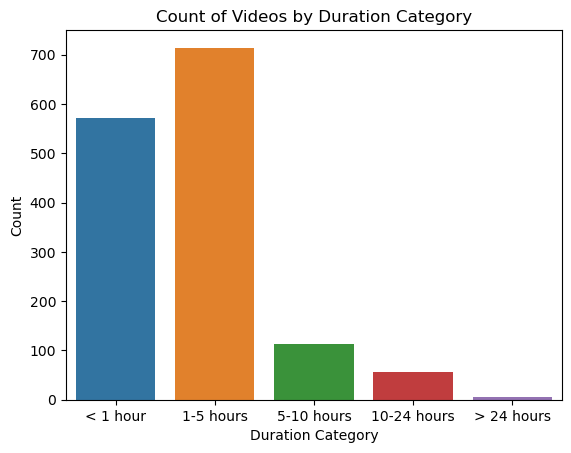

In [12]:


# Count the occurrences of each category
category_counts = fcc_df['category'].value_counts().reset_index()

# Rename the columns for better labeling
category_counts.columns = ['Category', 'Count']

# Create the count bar plot
sns.barplot(x='Category', y='Count', data=category_counts)

# Set labels and title
plt.xlabel('Duration Category')
plt.ylabel('Count')
plt.title('Count of Videos by Duration Category')

# Display the plot
plt.show()


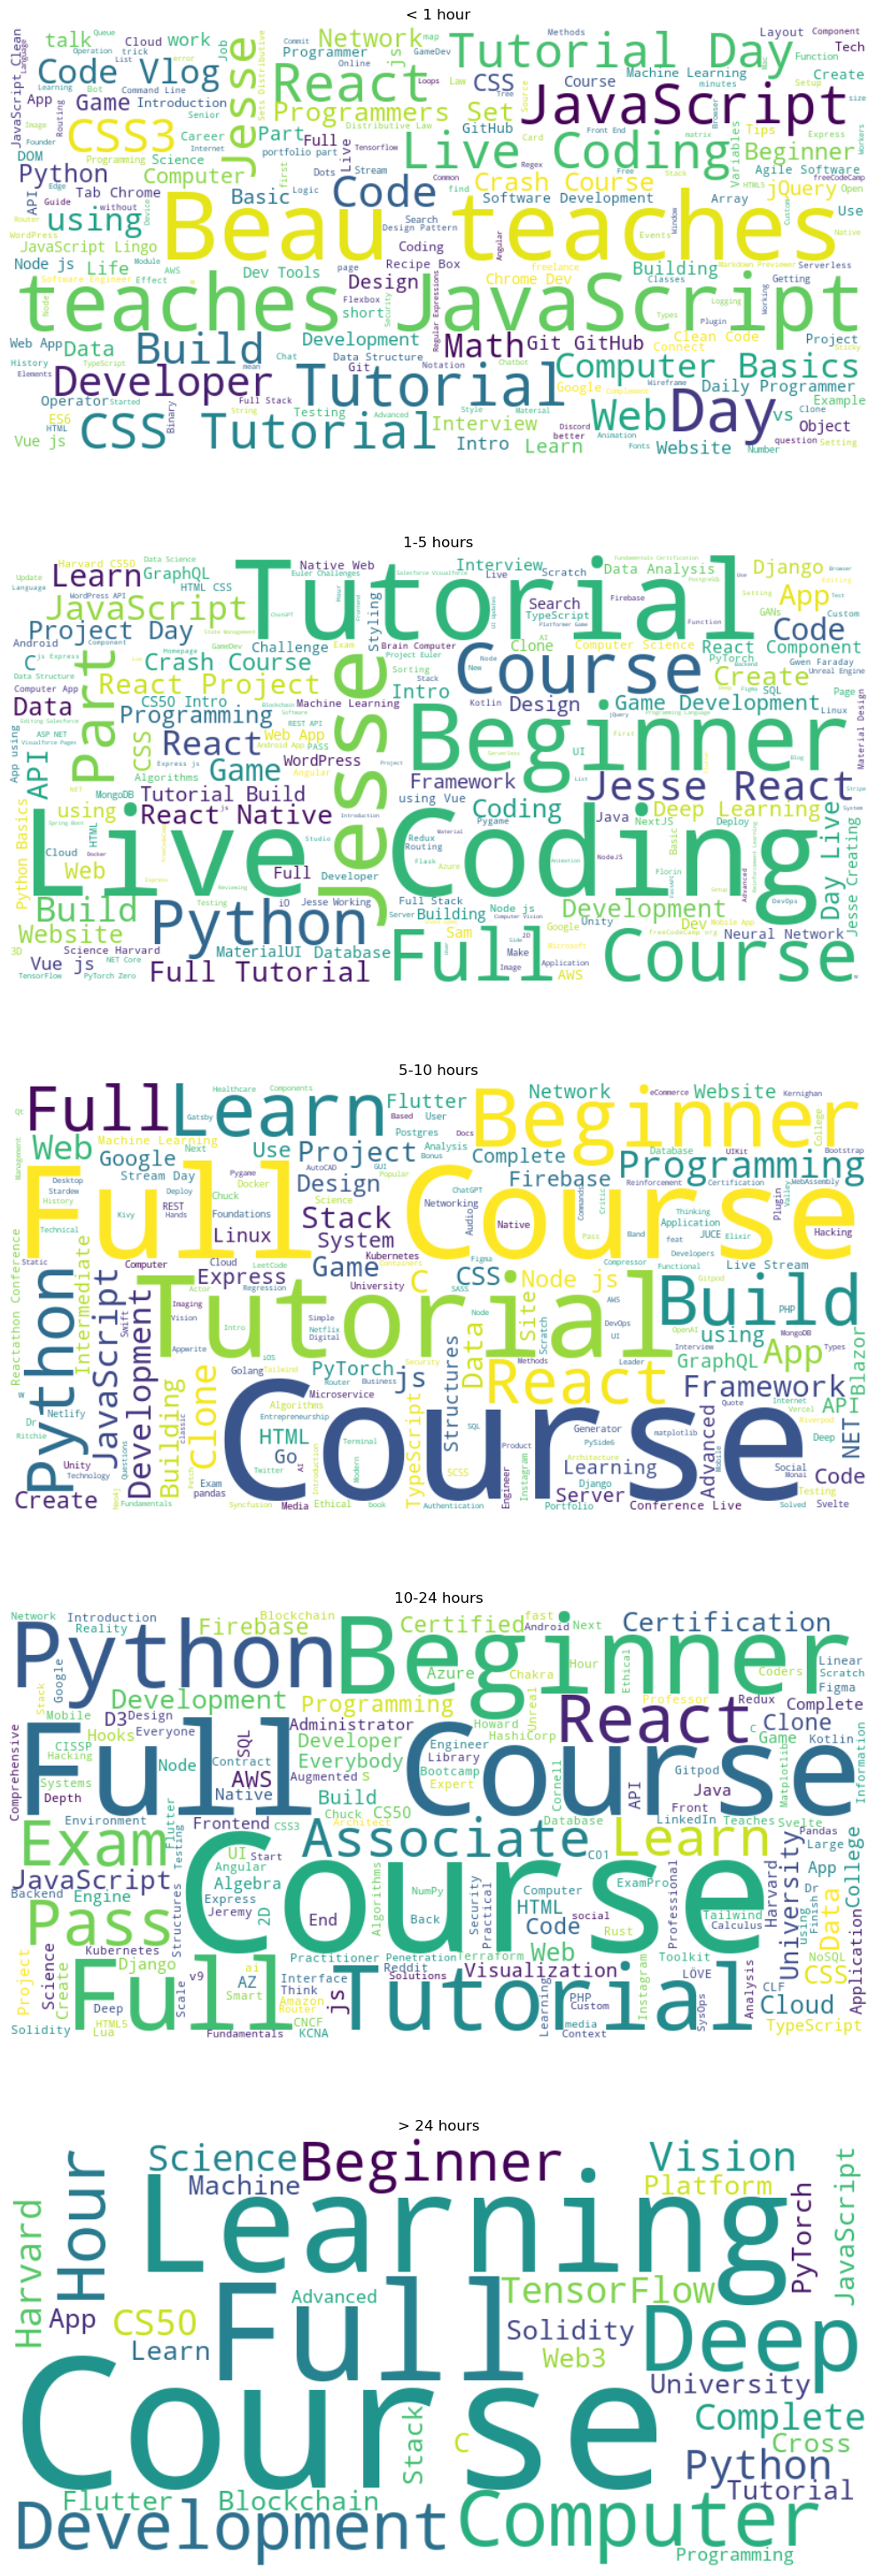

In [13]:
category_groups = fcc_df.groupby('category')

# Create subplots for each category's word cloud
fig, axes = plt.subplots(nrows=len(category_groups),
                         ncols=1, figsize=(10, 6*len(category_groups)))

# Generate word clouds and plot them in subplots
for i, (category, group) in enumerate(category_groups):
    # Combine all text in the category into a single string
    text = ' '.join(group['title'])

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400,
                          background_color='white').generate(text)

    # Plot word cloud in subplot
    ax = axes[i]
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(category)
    ax.axis('off')

# Adjust subplot spacing
plt.tight_layout()

# Display the subplots
plt.show()


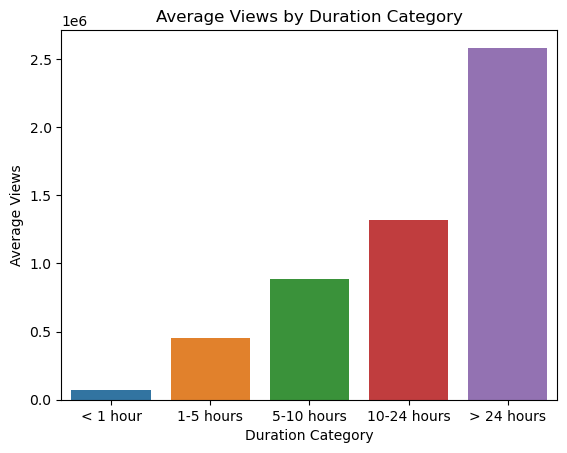

In [14]:
average_views = fcc_df.groupby('category')['viewCount'].mean().reset_index()

# Create the bar plot
sns.barplot(x='category', y='viewCount', data=average_views)

# Set labels and title
plt.xlabel('Duration Category')
plt.ylabel('Average Views')
plt.title('Average Views by Duration Category')

# Display the plot
plt.show()